In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import chart_studio
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [7]:
pip install chart_studio

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# READING DATA

In [0]:
dft = pd.read_csv('/content/drive/My Drive/6_Donors_choose_NB/train_data.csv',nrows=50000)
dfr = pd.read_csv('/content/drive/My Drive/6_Donors_choose_NB/resources.csv')

In [10]:
print("Number of data points in train data", dft.shape)
print('-'*50)
print("The attributes of data :", dft.columns.values)

Number of data points in train data (50000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [11]:
print("Number of data points in train data", dfr.shape)
print(dfr.columns.values)
dfr.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity   price
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1  149.00
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   14.95

In [12]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(dft.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
dft['Date'] = pd.to_datetime(dft['project_submitted_datetime'])
dft.drop('project_submitted_datetime', axis=1, inplace=True)
dft.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
dft = dft[cols]


dft.head(2)

Unnamed: 0  ... project_is_approved
473        100660  ...                   1
41558       33679  ...                   1

[2 rows x 17 columns]

# TEXT PROCESSING

In [0]:
# merge two column text dataframe: 
dft["essay"] = dft["project_essay_1"].map(str) +\
                        dft["project_essay_2"].map(str) + \
                        dft["project_essay_3"].map(str) + \
                        dft["project_essay_4"].map(str)

In [14]:
dft.head(2)

Unnamed: 0  ...                                              essay
473        100660  ...  I recently read an article about giving studen...
41558       33679  ...  My students crave challenge, they eat obstacle...

[2 rows x 18 columns]

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
# specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
# general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [0]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

# Preprocessing of project_subject_categories

In [0]:
catogories = list(dft['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
dft['clean_categories'] = cat_list
dft.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in dft['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

# Preprocessing of project_subject_subcategories

In [0]:
sub_catogories = list(dft['project_subject_subcategories'].values)
# remove special characters from list of strings python:
#https://stackoverflow.com/a/47301924/4084039

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

dft['clean_subcategories'] = sub_cat_list
dft.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: 
#https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in dft['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [19]:
# we have to remove the grades from every row
print(dft['project_grade_category'][:20])

473      Grades PreK-2
41558       Grades 3-5
29891       Grades 3-5
23374    Grades PreK-2
49228    Grades PreK-2
7176     Grades PreK-2
35006       Grades 3-5
5145        Grades 3-5
48237      Grades 9-12
46375       Grades 3-5
36468    Grades PreK-2
36358    Grades PreK-2
39438    Grades PreK-2
2521     Grades PreK-2
40180    Grades PreK-2
25460       Grades 6-8
34399       Grades 3-5
5364        Grades 6-8
47478      Grades 9-12
45858       Grades 3-5
Name: project_grade_category, dtype: object


In [0]:
d= list(dft['project_grade_category'].values)
# remove special characters from list of strings python:
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

grade_cat_list = []
for i in d:
# consider we have text like this:
    for j in i.split(' '): # # split by space
        j=j.replace('Grades','')# clean grades from the row
    grade_cat_list.append(j.strip())
    
dft['clean_grade'] = grade_cat_list
dft.drop(['project_grade_category'], axis=1, inplace=True)

my_counter = Counter()
for word in dft['clean_grade'].values:
     my_counter.update(word.split())
project_grade_category_dict= dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))

In [21]:
sorted_project_grade_category_dict

{'3-5': 16968, '6-8': 7750, '9-12': 4966, 'PreK-2': 20316}

# Preparing data for the models

# Test - Train Split

In [0]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dft, dft['project_is_approved'],stratify = dft['project_is_approved'], test_size=0.2)
X_train,X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [23]:
print(y_train.value_counts())
print(y_test.value_counts())
print(y_cv.value_counts())

1    27063
0     4937
Name: project_is_approved, dtype: int64
1    8457
0    1543
Name: project_is_approved, dtype: int64
1    6766
0    1234
Name: project_is_approved, dtype: int64


In [0]:
#droping the y labels
#https://stackoverflow.com/questions/13411544/delete-column-from-pandas-dataframe-by-column-name

X_train.drop(["project_is_approved"], axis = 1, inplace = True)

X_test.drop(["project_is_approved"], axis = 1, inplace = True)

X_cv.drop(["project_is_approved"], axis = 1, inplace = True)


# Text preprocessing


In [25]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_essays_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_train.append(sent.lower().strip())


100%|██████████| 32000/32000 [00:15<00:00, 2088.08it/s]


In [26]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_essays_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_test.append(sent.lower().strip())

100%|██████████| 10000/10000 [00:04<00:00, 2100.58it/s]


In [27]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_essays_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays_cv.append(sent.lower().strip())


100%|██████████| 8000/8000 [00:03<00:00, 2093.21it/s]


In [28]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_titles_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_cv.append(sent.lower().strip())

100%|██████████| 8000/8000 [00:00<00:00, 44965.99it/s]


In [29]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_titles_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_train.append(sent.lower().strip())


100%|██████████| 32000/32000 [00:00<00:00, 44673.57it/s]


In [30]:
#Proprocessing for essay
# Combining all the above students
from tqdm import tqdm
preprocessed_titles_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles_test.append(sent.lower().strip())

100%|██████████| 10000/10000 [00:00<00:00, 42365.38it/s]


# Encoding numerical, Categorical features

# vectorize categorical data

In [31]:
#project_subject_categories convert categorical to vectors

# convert train,cv and test data of clean_categories into vectors
# we use count vectorizer to convert the values into one
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(lowercase=False,binary=True)
vectorizer1.fit(X_train['clean_categories'].values)
# firstly convert fit the train data into the vectoriaer then it learn hte vocablery
# we use the fitted CountVectorizer to convert the text to vector
X_train_cat = vectorizer1.transform(X_train['clean_categories'].values)
X_cv_cat = vectorizer1.transform(X_cv['clean_categories'].values)
X_test_cat = vectorizer1.transform(X_test['clean_categories'].values)
print(vectorizer1.get_feature_names())


['AppliedLearning', 'Care_Hunger', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds', 'Warmth']


In [32]:
f1=vectorizer1.get_feature_names()
print("After vectorizations")
print(X_train_cat.shape, y_train.shape)
print(X_cv_cat.shape, y_cv.shape)
print(X_test_cat.shape, y_test.shape)
print("="*100)


After vectorizations
(32000, 9) (32000,)
(8000, 9) (8000,)
(10000, 9) (10000,)


In [33]:
##project_subject_subcategories convert categorical to vectors
# convert train,cv and test data of clean_categories into vectors
# we use count vectorizer to convert the values into one
from sklearn.feature_extraction.text import CountVectorizer
vectorizer2 = CountVectorizer(lowercase=False, binary=True)
vectorizer2.fit(X_train['clean_subcategories'].values)
# firstly convert fit the train data into the vectoriaer then it learn hte vocablery
# we use the fitted CountVectorizer to convert the text to vector
X_train_subcat = vectorizer2.transform(X_train['clean_subcategories'].values)
X_cv_subcat = vectorizer2.transform(X_cv['clean_subcategories'].values)
X_test_subcat = vectorizer2.transform(X_test['clean_subcategories'].values)
print(vectorizer2.get_feature_names())

['AppliedSciences', 'Care_Hunger', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts', 'Warmth']


In [34]:
print("After vectorizations")
print(X_train_subcat.shape, y_train.shape)
print(X_cv_subcat.shape, y_cv.shape)
print(X_test_subcat.shape, y_test.shape)
print("="*100)

After vectorizations
(32000, 30) (32000,)
(8000, 30) (8000,)
(10000, 30) (10000,)


In [35]:
# school_state convert categorical to vectors
# now time to cont the each words
from collections import Counter
my_counter = Counter()
for word in dft['school_state'].values:
    my_counter.update(word.split())# count the words
school_state_dict = dict(my_counter)# store in dicionary
sorted_school_state_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1]))
print(sorted_school_state_dict)

{'VT': 32, 'WY': 51, 'ND': 63, 'MT': 106, 'RI': 126, 'NH': 141, 'SD': 142, 'NE': 144, 'AK': 153, 'DE': 155, 'WV': 218, 'ME': 222, 'NM': 236, 'HI': 239, 'DC': 247, 'KS': 285, 'ID': 302, 'IA': 306, 'AR': 446, 'CO': 538, 'MN': 556, 'OR': 577, 'MS': 598, 'KY': 614, 'NV': 665, 'MD': 668, 'TN': 774, 'CT': 774, 'AL': 790, 'UT': 792, 'WI': 833, 'VA': 916, 'AZ': 994, 'NJ': 1005, 'OK': 1074, 'MA': 1076, 'LA': 1094, 'WA': 1103, 'MO': 1166, 'IN': 1171, 'OH': 1180, 'PA': 1419, 'MI': 1468, 'GA': 1828, 'SC': 1830, 'IL': 1967, 'NC': 2340, 'FL': 2839, 'TX': 3320, 'NY': 3393, 'CA': 7024}


In [36]:
# convert train,cv and test data of clean_categories into vectors
# we use count vectorizer to convert the values into one
from sklearn.feature_extraction.text import CountVectorizer
vectorizer3 = CountVectorizer(lowercase=False, binary=True)
vectorizer3.fit(dft['school_state'].values)
# firstly convert fit the train data into the vector then it learn the vocablery
# we use the fitted CountVectorizer to convert the text to vector
X_train_school_state = vectorizer3.transform(X_train['school_state'].values)
X_cv_school_state = vectorizer3.transform(X_cv['school_state'].values)
X_test_school_state = vectorizer3.transform(X_test['school_state'].values)
print(vectorizer3.get_feature_names())

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


In [37]:
print("After vectorizations")
print(X_train_school_state .shape, y_train.shape)
print(X_cv_school_state .shape, y_cv.shape)
print(X_test_school_state .shape, y_test.shape)
print("="*100)

After vectorizations
(32000, 51) (32000,)
(8000, 51) (8000,)
(10000, 51) (10000,)


In [38]:
#project_grade_category categorical to vectors
#https://stackoverflow.com/questions/42224700/attributeerror-float-object-has-no-attribute-split
dft['clean_grade']=dft['clean_grade'].fillna("")# fill the null values with space
# convert train,cv and test data of clean_categories into vectors
# we use count vectorizer to convert the values into one
from sklearn.feature_extraction.text import CountVectorizer
vectorizer4 = CountVectorizer(vocabulary=list(sorted_project_grade_category_dict.keys()),
lowercase=False, binary=True)
vectorizer4.fit(dft['clean_grade'].values)
# firstly convert fit the train data into the vectoriaer then it learn hte vocablery
# we use the fitted CountVectorizer to convert the text to vector
X_train_project_grade_category = vectorizer4.transform(X_train['clean_grade'].values)
X_cv_project_grade_category = vectorizer4.transform(X_cv['clean_grade'].values)
X_test_project_grade_category = vectorizer4.transform(X_test['clean_grade'].values)
print(vectorizer4.get_feature_names())

['9-12', '6-8', '3-5', 'PreK-2']


In [39]:
print("After vectorizations")
print(X_train_project_grade_category .shape, y_train.shape)
print(X_cv_project_grade_category .shape, y_cv.shape)
print(X_test_project_grade_category .shape, y_test.shape)
print("="*100)

After vectorizations
(32000, 4) (32000,)
(8000, 4) (8000,)
(10000, 4) (10000,)


In [0]:
#teacher_prefix categorical to vectors
#https://stackoverflow.com/questions/42224700/attributeerror-float-object-has-no-attribute-split
dft['teacher_prefix']=dft['teacher_prefix'].fillna(" ")# filll the null valueswith space
my_counter = Counter()
for word in dft['teacher_prefix'].values:
    my_counter.update(word.split())
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
teacher_cat_dict = dict(my_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_cat_dict.items(), key=lambda kv: kv[1]))

In [41]:
# convert train,cv and test data of clean_categories into vectors
# we use count vectorizer to convert the values into one
from sklearn.feature_extraction.text import CountVectorizer
vectorizer5 = CountVectorizer(lowercase=False,binary=True)
vectorizer5.fit(dft['teacher_prefix'].values.astype('U'))
# firstly convert fit the train data into the vectorizer 
# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_prefix = vectorizer5.transform(X_train['teacher_prefix'].values.astype('U'))
X_cv_teacher_prefix= vectorizer5.transform(X_cv['teacher_prefix'].values.astype('U'))
X_test_teacher_prefix = vectorizer5.transform(X_test['teacher_prefix'].values.astype('U'))
print(vectorizer5.get_feature_names())

['Dr', 'Mr', 'Mrs', 'Ms', 'Teacher']


In [42]:
print("After vectorizations")
print(X_train_teacher_prefix .shape, y_train.shape)
print(X_cv_teacher_prefix .shape, y_cv.shape)
print(X_test_teacher_prefix .shape, y_test.shape)
print("="*100)

After vectorizations
(32000, 5) (32000,)
(8000, 5) (8000,)
(10000, 5) (10000,)


# Encoding essay, and Project_title

# Tfidf featurization

In [0]:
X_train_essay=preprocessed_essays_train
X_cv_essay=preprocessed_essays_cv
X_test_essay=preprocessed_essays_test

X_train_title=preprocessed_titles_train
X_cv_title=preprocessed_titles_cv
X_test_title=preprocessed_titles_test

In [44]:
#for titles
from sklearn.feature_extraction.text import TfidfVectorizer
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer8 = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
vectorizer8.fit(X_train_title)# that is learned from trained data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_title = vectorizer8.transform(X_train_title)
X_cv_tf_title= vectorizer8.transform(X_cv_title)
X_test_tf_title = vectorizer8.transform(X_test_title)
print("After vectorizations")
print(X_train_tf_title.shape, y_train.shape)
print(X_cv_tf_title.shape, y_cv.shape)
print(X_test_tf_title.shape, y_test.shape)
print("="*100)


After vectorizations
(32000, 2242) (32000,)
(8000, 2242) (8000,)
(10000, 2242) (10000,)


In [45]:
#for essay
from sklearn.feature_extraction.text import TfidfVectorizer
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer9 = TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(1, 2))
vectorizer9.fit(X_train_essay)# that is learned from trained data
# we use the fitted CountVectorizer to convert the text to vector
X_train_tf_essay = vectorizer9.transform(X_train_essay)
X_cv_tf_essay= vectorizer9.transform(X_cv_essay)
X_test_tf_essay = vectorizer9.transform(X_test_essay)
print("After vectorizations")
print(X_train_tf_essay.shape, y_train.shape)
print(X_cv_tf_essay.shape, y_cv.shape)
print(X_test_tf_essay.shape, y_test.shape)
print("="*100)

After vectorizations
(32000, 5000) (32000,)
(8000, 5000) (8000,)
(10000, 5000) (10000,)


# Using Pretrained Models : AVG W2V

In [0]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039

def loadGloveModel(gloveFile):
    
    print ("Loading Glove Model")
    
    f = open(gloveFile,'r', encoding = 'utf8')
    
    model = {}
    
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    
    print ("Done.",len(model)," words loaded!")
    
    return model


In [47]:
 model = loadGloveModel('/content/drive/My Drive/Classroom/glove.6B.300d.txt')

1075it [00:00, 10742.40it/s]

Loading Glove Model


400000it [00:36, 10926.52it/s]

Done. 400000  words loaded!


In [0]:
glove_words = set(model.keys()) 

# Using Pretrained Models: TFIDF weighted W2V

In [0]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [0]:
# average Word2Vec
# compute average word2vec for each review.
def tf_idf_done(word_list):
    train_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(word_list): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split():#.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
              #vec = model.wv[word]  
              vec = model[word] # getting the vector for each word
# here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        train_title_tfidf_w2v_vectors.append(vector)
    print(len(train_title_tfidf_w2v_vectors))
    print(len(train_title_tfidf_w2v_vectors[0]))
    return train_title_tfidf_w2v_vectors


In [51]:
train_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_train)
test_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_test)
cv_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_cv)


  1%|          | 55/10000 [00:00<00:18, 539.94it/s]

32000
300


  1%|          | 57/8000 [00:00<00:13, 568.14it/s]

10000
300


100%|██████████| 8000/8000 [00:13<00:00, 573.90it/s]

8000
300


In [52]:
train_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_train)
test_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_test)
cv_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_cv)

 17%|█▋        | 1655/10000 [00:00<00:00, 16541.85it/s]

32000
300


 39%|███▉      | 3129/8000 [00:00<00:00, 31281.83it/s]

10000
300


100%|██████████| 8000/8000 [00:00<00:00, 26884.47it/s]

8000
300


# Vectorizing Numerical features

In [53]:
price_data = dfr.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
dft = pd.merge(dft, price_data, on='id', how='left')
print(price_data.head(2))
# we also have to do this in tran,test and cv
# so also merge the resource data with the trian,cv and test
X_train = pd.merge(X_train, price_data, on = "id", how = "left")
#print(x_train.columns)
X_test = pd.merge(X_test, price_data, on = "id", how = "left")
X_cv = pd.merge(X_cv, price_data, on = "id", how = "left")

        id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21


In [0]:
#standardization
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikitlearn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing


price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviationof this data
#print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above mean and variance.
train_price_standar = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
# Now standardize the data with above maen and variance.
test_price_standar = price_scalar.transform(X_test['price'].values.reshape(-1, 1))
# Now standardize the data with above maen and variance.
cv_price_standar = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))

In [0]:
# previous_year_projects
price_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
#print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above maen and variance.
train_prev_proj_standar =price_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
# Now standardize the data with above maen and variance.
test_prev_proj_standar =price_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
# Now standardize the data with above maen and variance.
cv_prev_proj_standar = price_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))


In [0]:
price_scalar.fit(X_train['quantity'].values.reshape(-1,1)) # finding the mean and standarddeviation of this data
#print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above maen and variance.
train_qnty_standar = price_scalar.transform(X_train['quantity'].values.reshape(-1, 1))
# Now standardize the data with above maen and variance.
cv_qnty_standar = price_scalar.transform(X_cv['quantity'].values.reshape(-1, 1))
# Now standardize the data with above maen and variance.
test_qnty_standar = price_scalar.transform(X_test['quantity'].values.reshape(-1, 1))

# merging


In [57]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :) 
X_set2_train = hstack((X_train_tf_essay,X_train_tf_title,
                       X_train_teacher_prefix,X_train_cat,X_train_subcat,
                       X_train_project_grade_category,X_train_school_state,
                       train_qnty_standar,train_price_standar,train_prev_proj_standar))
print(X_set2_train.shape, y_train.shape)

(32000, 7344) (32000,)


In [58]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set2_cv = hstack((X_cv_tf_essay,X_cv_tf_title,
                    X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,
                    X_cv_project_grade_category,X_cv_school_state,
                    cv_qnty_standar,cv_price_standar,cv_prev_proj_standar))
print(X_set2_cv.shape, y_cv.shape)

(8000, 7344) (8000,)


In [59]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set2_test = hstack((X_test_tf_essay,X_test_tf_title,
                      X_test_teacher_prefix,X_test_cat,X_test_subcat,
                      X_test_project_grade_category,X_test_school_state,
                      test_qnty_standar,test_price_standar,test_prev_proj_standar)).tocsr()
print(X_set2_test.shape, y_test.shape)


(10000, 7344) (10000,)


In [60]:
import numpy
s=numpy.array(train_tfidf_w2v_vectors)
print(X_train_project_grade_category.shape)
print(s.shape)


(32000, 4)
(32000, 300)


In [61]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set4_train =hstack((train_tfidf_w2v_vectors, train_title_tfidf_w2v_vectors,train_prev_proj_standar,
                     train_price_standar,train_qnty_standar,
                      X_train_teacher_prefix,X_train_cat,X_train_subcat,
                      X_train_project_grade_category,X_train_school_state))

print(X_set4_train.shape, y_train.shape)

(32000, 702) (32000,)


In [62]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set4_cv =hstack((cv_tfidf_w2v_vectors,cv_title_tfidf_w2v_vectors,cv_prev_proj_standar,
                   cv_price_standar,cv_qnty_standar,
                   X_cv_teacher_prefix,X_cv_cat,X_cv_subcat,
                   X_cv_project_grade_category,X_cv_school_state))


print(X_set4_cv.shape, y_cv.shape)


(8000, 702) (8000,)


In [63]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_set4_test = hstack((test_title_tfidf_w2v_vectors,test_tfidf_w2v_vectors,test_prev_proj_standar,test_price_standar,test_qnty_standar,X_test_teacher_prefix,X_test_cat,X_test_subcat,
                      X_test_project_grade_category,X_test_school_state))
print(X_set4_test.shape, y_test.shape)

(10000, 702) (10000,)


# Applying Decision trees on TFIDF

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt2 = DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
clf2 = GridSearchCV(dt2, parameters, cv=3, scoring='roc_auc',return_train_score=True)
se2 = clf2.fit(X_set2_train, y_train)

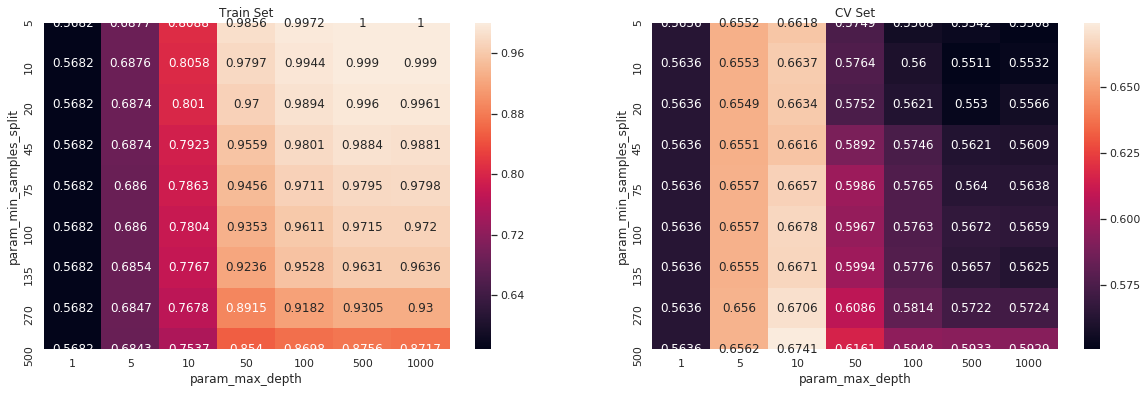

In [65]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf2.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

# Best Estimator and Best tune parameters

In [66]:
print(clf2.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf2.score(X_set2_train,y_train))
print(clf2.score(X_set2_test,y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.7542826631033414
0.6573400828912165


In [0]:
# Best tune parameters
best_tune_parameters=[{'max_depth':[10], 'min_samples_split':[500] }]

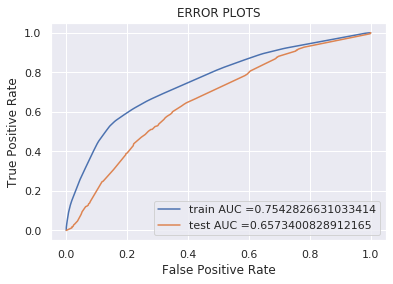

In [68]:
#*Fitting Model to Hyper-Parameter Curve
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11= GridSearchCV( DecisionTreeClassifier(class_weight = 'balanced'),best_tune_parameters)
clfV1=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)
clf11.fit(X_set2_train, y_train)
# for visulation
clfV1.fit(X_set2_train, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_set2_train) [:,1]
y_test_pred1 = clf11.predict_proba(X_set2_test) [:,1]

train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

# Confusion matrix

In [0]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),2) , "for threshold", np.round(t,2))
    predictions = []
    global predictions1 # make it global
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1= predictions
    return predictions

the maximum value of tpr*(1-fpr) 0.48 for threshold 0.41
the maximum value of tpr*(1-fpr) 0.39 for threshold 0.41


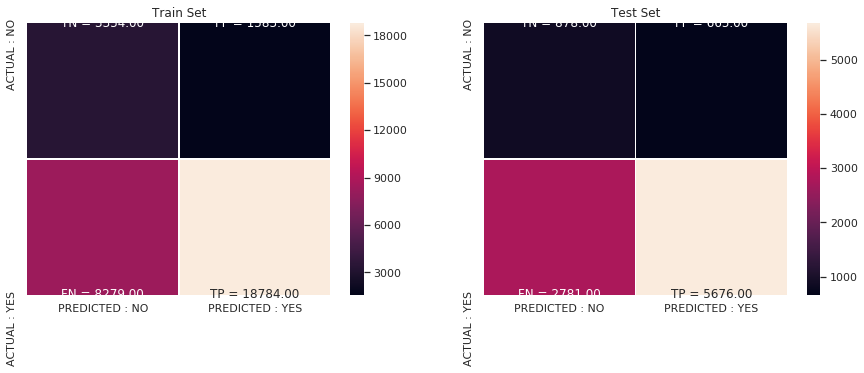

In [70]:
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
con_m_test.flatten())])).reshape(2,2)
sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()


# Visualizing Decision Tree

In [0]:
#Feature aggregation
f1=vectorizer1.get_feature_names()
f2=vectorizer2.get_feature_names()
f3=vectorizer3.get_feature_names()
f4=vectorizer4.get_feature_names()
f5=vectorizer5.get_feature_names()
#fb=vectorizer6.get_feature_names()
#ft=vectorizer7.get_feature_names()
fb1=vectorizer8.get_feature_names()
ft1=vectorizer9.get_feature_names()

feature_agg_tfidf = f1 + f2 + f3 + f4 + f5 + fb1 + ft1
# p is price, q is quantity, t is teacher previous year projects

feature_agg_tfidf.append('price')
feature_agg_tfidf.append('quantity')
feature_agg_tfidf.append('teacher_previous_projects')

# Analysis on the False positives

In [72]:
#Get the False positives datapoints
X_test['essay'].values[1]

'My students are bundles of potential and full of possibilities. \\r\\n\\r\\nThey are athletes, writers, and musicians; they are brothers, sisters, and some are still looking for a place to belong; they are eager to try new things, yet still timid to look inside themselves and reflect upon their experiences. \\r\\n\\r\\nOur school is located in the heart of a smalll, rural community. Sixty percent of our students are on free or reduced lunche Many students have never traveled more than 20 miles from where they live. Reading and writing are their pathways to experience the world beyond our rural community. Writing also provides them opportunities to share their life experiences, many of which are painful. Students become more confident of who they are and what they believe in my class. They carefully consider the biases they have and determine how they want to change the world.Part of the reading and writing experience is sharing; in fact, sharing is one of the most important aspects of

In [0]:
#https://www.google.com/search?q=geeks+for+geeks+false+positive&rlz=1C1SQJL_enIN849IN849&oq=geeks+for+geeks+false+positive&aqs=chrome..69i57j33l5.6431j0j7&sourceid=chrome&ie=UTF-8
#https://github.com/pskadasi/DecisionTrees_DonorsChoose/blob/master/Copy_of_8_DonorsChoose_DT_(1).ipynb
fpi = []
for i in range(len(y_test)) :
  if (y_test.values[i] == 0) & (predictions1[i] == 1) :
    fpi.append(i)
fp_essay1 = []
for i in fpi :
  fp_essay1.append(X_test['essay'].values[i])

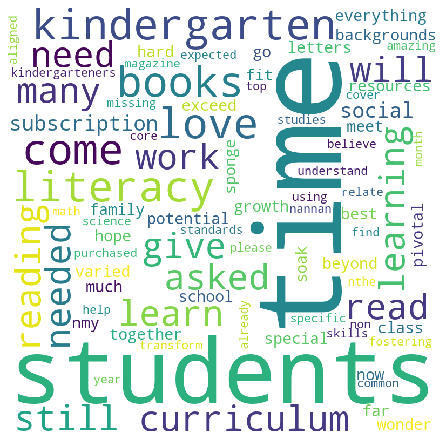

In [74]:
# Word cloud of essay
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay1 :
  val = str(val)
  tokens = val.split()
for i in range(len(tokens)):
  tokens[i] = tokens[i].lower()
for words in tokens :
  comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,
min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# DataFrame of False Positives

In [0]:
# first get the columns:
cols = X_test.columns
X_test_falsePos1 = pd.DataFrame(columns=cols)
# get the data of the false pisitives
for i in fpi : # (in fpi all the false positives data points indexes)
    X_test_falsePos1 = X_test_falsePos1.append(X_test.filter(items=[i], axis=0))

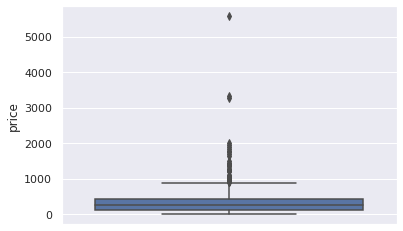

In [76]:
#Box Plot (FP 'price')
sns.boxplot(y='price', data=X_test_falsePos1)

In [0]:
import matplotlib.pyplot as plt

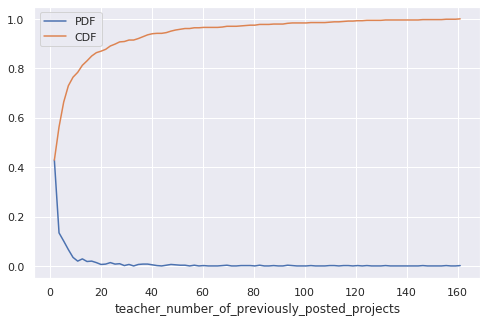

In [78]:
#PDF (FP ,teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos1['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

# Applying Decision trees on tf_idf W2V

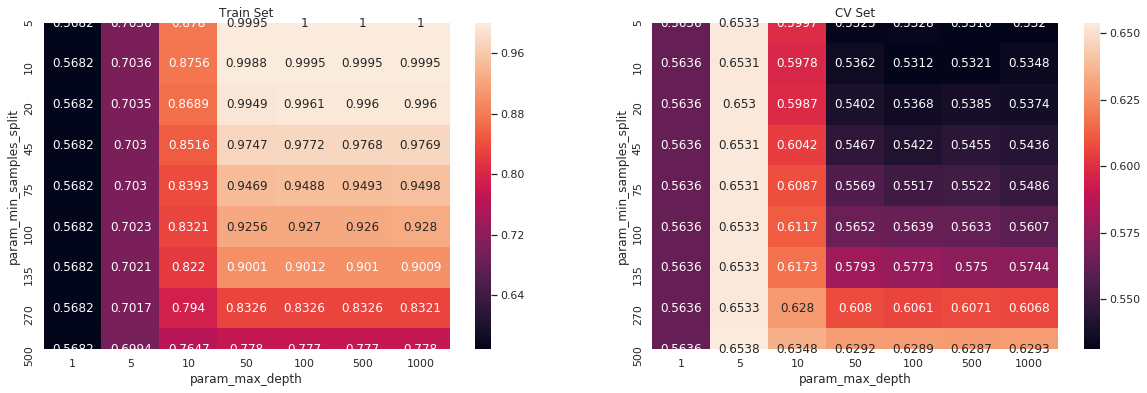

In [79]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt4= DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
clf4 = GridSearchCV(dt4, parameters, cv=3, scoring='roc_auc',return_train_score=True)
set4= clf4.fit(X_set4_train, y_train)

import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf4.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [80]:
#Best Estimator and Best tune parameters
print(clf4.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf4.score(X_set4_train,y_train))
print(clf4.score(X_set4_test,y_test))


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.6989437454737211
0.5969811369337362


In [0]:
best_tune_parameters= [{'max_depth': [5], 'min_samples_split':[500] }]

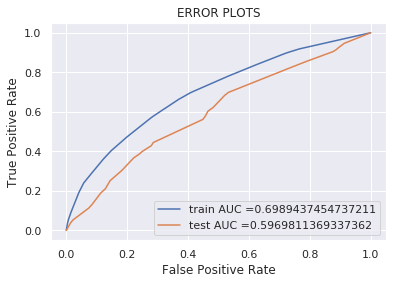

In [82]:
#Fitting Model to Hyper-Parameter Curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11= GridSearchCV( DecisionTreeClassifier(class_weight = 'balanced'),best_tune_parameters)
clfV1=DecisionTreeClassifier (class_weight = 'balanced',max_depth=5,min_samples_split=500)
clf11.fit(X_set4_train, y_train)
# for visulation
clfV1.fit(X_set4_train, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_set4_train) [:,1]
y_test_pred1 = clf11.predict_proba(X_set4_test) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.42 for threshold 0.5
the maximum value of tpr*(1-fpr) 0.33 for threshold 0.55


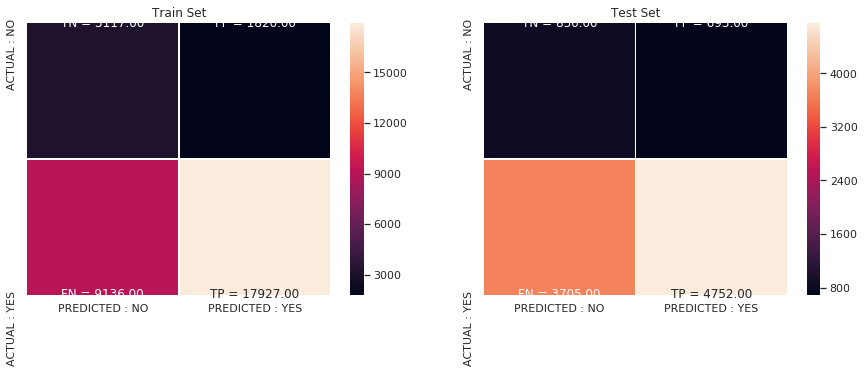

In [83]:
#CONFUSION MATRIX
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)
sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

In [0]:
#Analysis on the False positives
fpi = []
for i in range(len(y_test)) :
    if (y_test.values[i] == 0) & (predictions1[i] == 1) :
        fpi.append(i)
fp_essay1 = []
for i in fpi :
    fp_essay1.append(X_test['essay'].values[i])

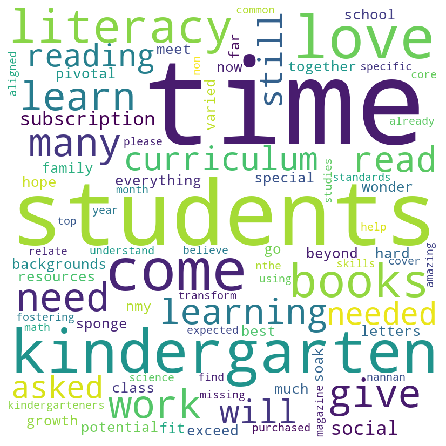

In [85]:
#WORD CLOUD OF ESSAY
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay1 :
    val = str(val)
    tokens = val.split()
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
for words in tokens :
    comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,
min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

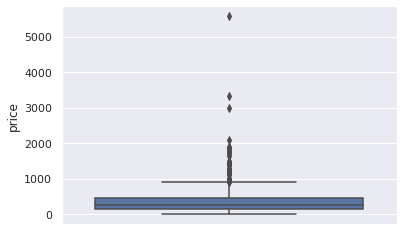

In [86]:
#Box Plot (FP 'price')
# first get the columns:
cols = X_test.columns
X_test_falsePos1 = pd.DataFrame(columns=cols)
# get the data of the false pisitives
for i in fpi : # (in fpi all the false positives data points indexes)
    X_test_falsePos1 = X_test_falsePos1.append(X_test.filter(items=[i], axis=0))
sns.boxplot(y='price', data=X_test_falsePos1)

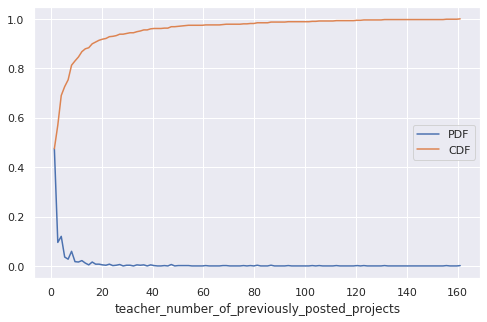

In [87]:
#PDF (FP ,teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos1['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

Select 5k best features from features of Set 2 using feature_importances,discard all the other remaining features and then apply any of the model of your choice i.e.(Dession tree, Logistic Regression, Linear SVM), you need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3

In [0]:
#https://stackoverflow.com/questions/47111434/randomforestregressor-and-feature-importances-error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def selectKImportance(model, X, k=5):
    return X[:,model.best_estimator_.feature_importances_.argsort()[::-1][:k]]

In [0]:

xtr = X_set2_train.tocsr()

In [90]:
# for tf-idf set 2
X_set5_train = selectKImportance(clf2, xtr,5000)
X_set5_test = selectKImportance(clf2, X_set2_test, 5000)

print(X_set5_train.shape)
print(X_set5_test.shape)

(32000, 5000)
(10000, 5000)


# Decision tree on Important features

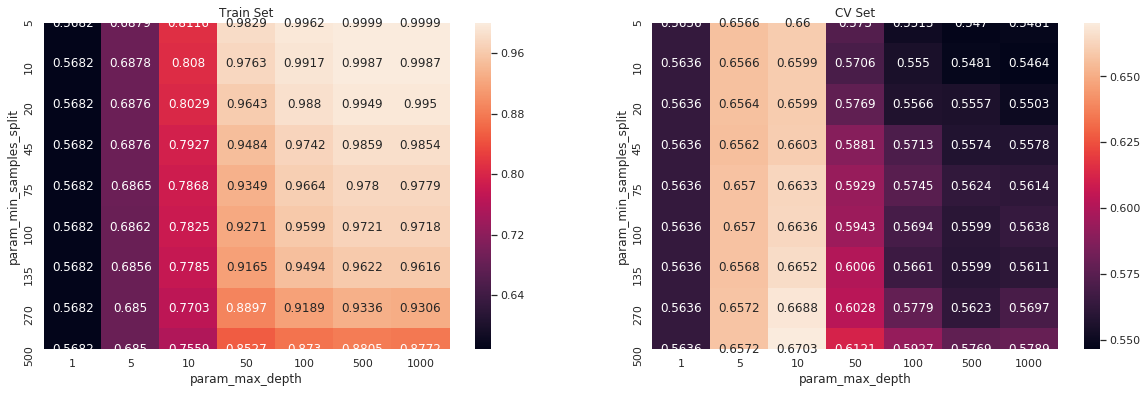

In [92]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dt5= DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]}
clf5 = GridSearchCV(dt5, parameters, cv=3, scoring='roc_auc',return_train_score=True)
set5= clf5.fit(X_set5_train, y_train)


import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf5.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [102]:
#Best Estimator and Best tune parameters
print(clf5.best_estimator_)
#Mean cross-validated score of the best_estimator
print(clf5.score(X_set5_train,y_train))
print(clf5.score(X_set5_test,y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.7542826631033414
0.6573400828912165


In [0]:
# Best tune parameters
best_tune_parameters=[{'max_depth': [10], 'min_samples_split':[500] } ]

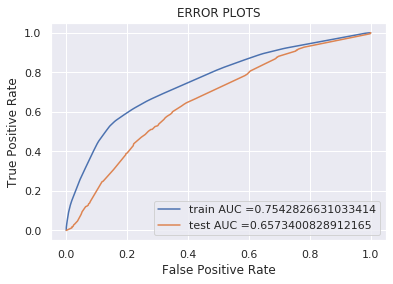

In [104]:
# train with best hyperparameter
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
clf11= GridSearchCV( DecisionTreeClassifier(class_weight = 'balanced'),best_tune_parameters)
clfV1=DecisionTreeClassifier (class_weight = 'balanced',max_depth=10,min_samples_split=500)
clf11.fit(X_set5_train, y_train)
# for visulation
clfV1.fit(X_set5_train, y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred1 = clf11.predict_proba(X_set5_train) [:,1]
y_test_pred1 = clf11.predict_proba(X_set5_test) [:,1]
train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)
plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

the maximum value of tpr*(1-fpr) 0.48 for threshold 0.41
the maximum value of tpr*(1-fpr) 0.39 for threshold 0.41


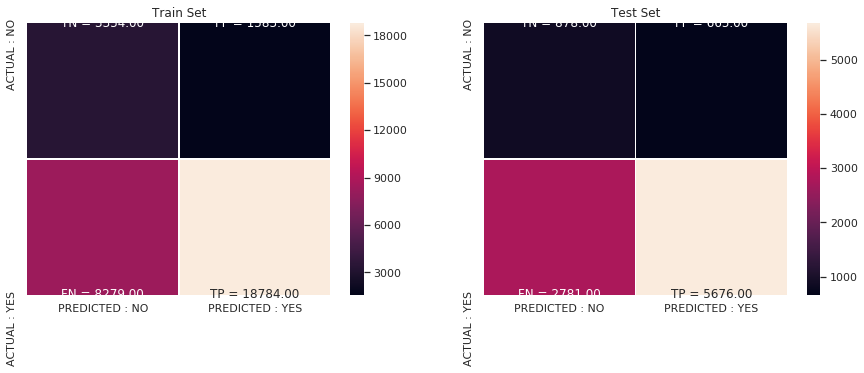

In [105]:
#CONFUSION MATRIX
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()
con_m_train = confusion_matrix(y_train, predict(y_train_pred1, tr_thresholds1, train_fpr1, train_tpr1))
con_m_test = confusion_matrix(y_test, predict(y_test_pred1, te_thresholds1, test_fpr1, test_tpr1))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),
con_m_test.flatten())])).reshape(2,2)
sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

In [0]:
#Analysis on the False positives

fpi = []
for i in range(len(y_test)) :
    if (y_test.values[i] == 0) & (predictions1[i] == 1) :
        fpi.append(i)
fp_essay1 = []
for i in fpi :
    fp_essay1.append(X_test['essay'].values[i])

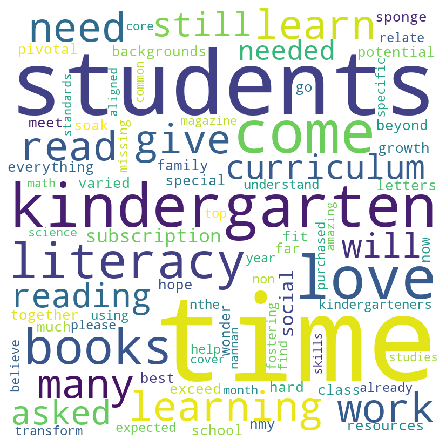

In [107]:
# Word cloud of essay
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in fp_essay1 :
    val = str(val)
    tokens = val.split()
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
for words in tokens :
    comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

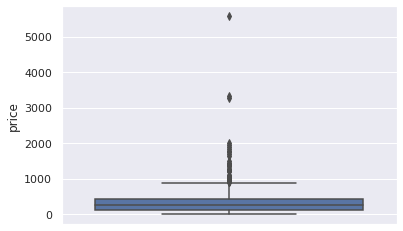

In [108]:
#Box Plot (FP 'price')
# first get the columns:
cols = X_test.columns
X_test_falsePos1 = pd.DataFrame(columns=cols)
# get the data of the false pisitives
for i in fpi : # (in fpi all the false positives data points indexes)
    X_test_falsePos1 = X_test_falsePos1.append(X_test.filter(items=[i], axis=0))
sns.boxplot(y='price', data=X_test_falsePos1)

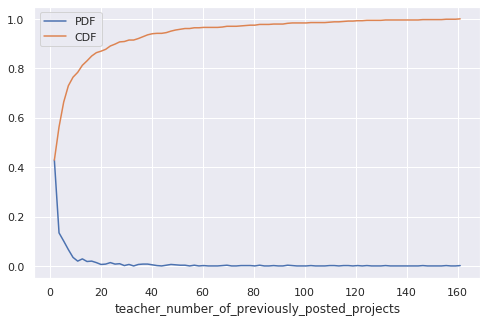

In [109]:
#PDF (FP ,teacher_number_of_previously_posted_projects)
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(X_test_falsePos1['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.show()

# Conclusions

In [110]:
# Please compare all your models using Prettytable library
#how to use pretty table http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Vectorizer ", " Max_depth ", " Min_sample_split "," Test -AUC ")
tb.add_row([" Tf - Idf", 10 , 500 ,65.7])
tb.add_row(["Tf - Idf-w2v", 5 , 500 ,59.6])
tb.add_row(["Top 5000 Features", 10, 500 ,65.7 ])
print(tb.get_string(titles = "Decision trees- Observations")) 

+-------------------+-------------+--------------------+-------------+
|     Vectorizer    |  Max_depth  |  Min_sample_split  |  Test -AUC  |
+-------------------+-------------+--------------------+-------------+
|      Tf - Idf     |      10     |        500         |     65.7    |
|    Tf - Idf-w2v   |      5      |        500         |     59.6    |
| Top 5000 Features |      10     |        500         |     65.7    |
+-------------------+-------------+--------------------+-------------+
